In [1]:
#insert path and file names here - data files should be saved in .txt
path = 
file = 
file2 = 
TTneeded = ["H", "L"]


# Statistical learning in ASD
Data preparation for the article "Intact predictive processing in autistic adults – evidence from statistical learning" (Pesthy et al., submitted)

In [8]:
import pandas as pd
import os as os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



#outlier filtering:

#calc boundaries

def calc_outlier_boundaries(TT, val, data, top_or_bottom):
    q1 = data[data["TT"] == TT].groupby("epoch").quantile(0.25)[val].to_numpy()
    q3 = data[data["TT"] == TT].groupby("epoch").quantile(0.75)[val].to_numpy()
    if top_or_bottom == "top":
        return q3 + 1.5 * (q3 - q1)
    else:
        return q1 - 1.5 * (q3 - q1)

    
def get_boundaries(value, data):
    outlier_top_lim_H = calc_outlier_boundaries("H", value, data, "top")
    outlier_top_lim_L = calc_outlier_boundaries("L", value, data, "top")
    outlier_bottom_lim_H = calc_outlier_boundaries("H", value, data, "bottom")
    outlier_bottom_lim_L = calc_outlier_boundaries("L", value, data, "bottom")
    return outlier_top_lim_H, outlier_top_lim_L, outlier_bottom_lim_H, outlier_bottom_lim_L



def raw_RT_boxplot_like_a_boss(value, data):
    #print(epoch, value, TT)
    outlier = []
    sns.set(rc = {'figure.figsize':(15,8)})
    plotname = sns.boxplot(y = value, data = data)

    #iterate through the data and add label to the plot
    #and btw create an outlier column based on which we can filter later on
    
    row_RT = data.columns.get_loc(value)
    row_sub = data.columns.get_loc("Subject")
    
    
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    outlier_top_lim = q3 + 1.5 * (q3 - q1)
    outlier_bottom_lim = q1 - 1.5 * (q3 - q1)

    
    for index, row in data.iterrows():
        value_to_check = row[row_RT]
        if value_to_check > outlier_top_lim or value_to_check < outlier_bottom_lim:
            outlier.append(1)
            #print(f'Outlier in row {index}: subject {row[row_sub]}, RT: {value_to_check}')
        else:
            outlier.append(0)
    
    return plotname, outlier

def report_boxplot_results(data):
    outliers = data[data["outlier"] == 1]
    print(f'We found {len(outliers)} outlier RTs in {len(outliers["Subject"].unique())} subjects.')
    print(f'this is {round(len(data[data["outlier"] == 1]) / len(data) * 100, 2)}% of all RTs')
    sns.displot(data[data["outlier"] == 1], x="finalRT", multiple="stack")

#clumsy little data prep functions

def raw_data_read_and_clean(path, file, is_halfblock, TTneeded = ["H", "L"], is_RT_data = False):
    data = pd.read_csv(f"{path}/{file}", delimiter = "\t")
    data = data[["Subject", "TT", "epoch", "Block", "finalRT", "firstACC"]]
    data_TTfiltered = data[data.TT.isin(TTneeded)]
    if is_RT_data:
        data_TTfiltered = data_TTfiltered[data_TTfiltered["firstACC"] == 1]
    return data_TTfiltered


def simple_pivot(data_in, outcome_var, indeces, cols, aggfunct):
    data_out = pd.pivot_table(data_in, values = outcome_var, index = indeces, columns = cols, aggfunc = aggfunct)
    data_out.columns = [' '.join(str(col)).strip() for col in data_out.columns.values]
    data_out.reset_index(inplace=True)
    data_out.columns = data_out.columns.str.replace("[()'', ]", "")
    data_out.replace('', np.nan, inplace=True)
    data_out.dropna(axis = 0, inplace=True)
    return data_out


In [3]:
#raw1
data_TTfiltered = raw_data_read_and_clean(path, file, is_halfblock = False)

#raw2

data_TTfiltered2 = raw_data_read_and_clean(path, file2, is_halfblock = False)
data_TTfiltered2["epoch"] = data_TTfiltered2["epoch"]+4

#merge sessions
data_TTfiltered_allepochs = pd.concat([data_TTfiltered, data_TTfiltered2], ignore_index=True)
data_TTfiltered_allepochs.head(10)




,Subject,TT,epoch,Block,finalRT,firstACC
0,1,H,1,1,324,1
1,1,H,1,1,593,0
2,1,L,1,1,434,1
3,1,H,1,1,395,1
4,1,H,1,1,361,1
5,1,L,1,1,483,1
6,1,H,1,1,330,1
7,1,L,1,1,334,1
8,1,H,1,1,378,1
9,1,H,1,1,399,1


In [4]:
#drop subjects with false data
data_TTfiltered_allepochs = data_TTfiltered_allepochs[~data_TTfiltered_allepochs.Subject.isin([2,7,28])].reset_index(drop=True)
data_TTfiltered_allepochs["Subject"].unique()

array([  1,   3,   4,   5,   6,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  21,  22,  23, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122], dtype=int64)

## data inspection - outlier RT filtering

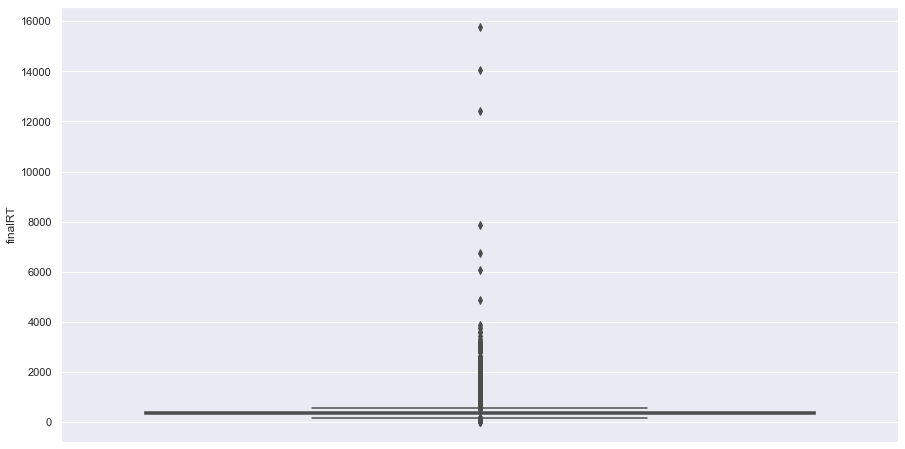

In [9]:
boxplot, outlier = raw_RT_boxplot_like_a_boss("finalRT", data_TTfiltered_allepochs)
data_TTfiltered_allepochs["outlier"] = outlier

We found 6681 outlier RTs in 42 subjects.
this is 5.83% of all RTs


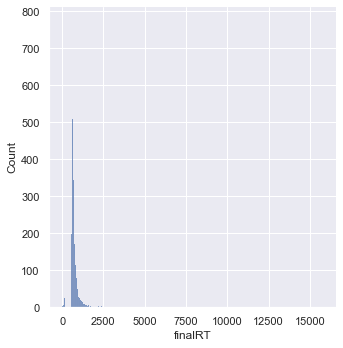

In [10]:
report_boxplot_results(data_TTfiltered_allepochs)

In [11]:
#filtering outliers
data_TTfiltered_allepochs_filtered = data_TTfiltered_allepochs[data_TTfiltered_allepochs['outlier'] == 0].reset_index(drop=True)

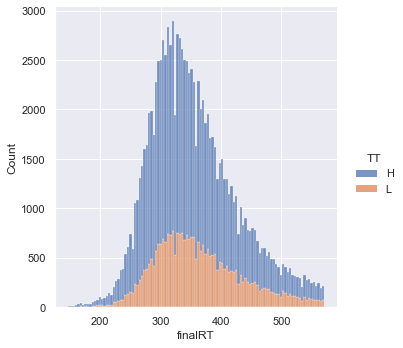

In [12]:
#visualization:
sns.displot(data_TTfiltered_allepochs_filtered, x="finalRT", hue="TT", multiple="stack")

## prep accuracy data

In [13]:
ACC_allepochs_long = data_TTfiltered_allepochs_filtered[["Subject", "TT", "epoch", "firstACC"]]

ACC_data = simple_pivot(ACC_allepochs_long, "firstACC", ["Subject", "epoch", "TT"], None, np.mean)
ACC_data["group"] = ACC_data['Subject'].apply(lambda x: "ASD" if x > 100 else "NTP")
ACC_data.head()



C:\Users\User\AppData\Local\Temp\ipykernel_11520\1941759611.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  data_out.columns = data_out.columns.str.replace("[()'', ]", "")


,Subject,epoch,TT,firstACC,group
0,1,1,H,0.978166,NTP
1,1,1,L,1.000000,NTP
2,1,2,H,0.987603,NTP
3,1,2,L,0.978022,NTP
4,1,3,H,1.000000,NTP


In [16]:
#wide data
ACC_allepochs_wide = simple_pivot(data_TTfiltered_allepochs_filtered, 'firstACC', 'Subject', ['epoch', 'TT'], 'mean')
ACC_allepochs_wide['group'] =ACC_allepochs_wide['Subject'].apply(lambda x: "ASD" if x > 100 else "NTP")
ACC_allepochs_wide.head()

C:\Users\User\AppData\Local\Temp\ipykernel_11520\1941759611.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  data_out.columns = data_out.columns.str.replace("[()'', ]", "")


,Subject,1H,1L,2H,2L,3H,3L,4H,4L,5H,5L,6H,6L,7H,7L,8H,8L,group
0,1,0.978166,1.000000,0.987603,0.978022,1.000000,1.000000,0.995763,1.000000,1.000000,1.000000,0.995918,1.000000,1.000000,0.989899,1.000000,1.000000,NTP
1,3,0.965368,0.941176,0.967480,0.962025,0.974684,0.951807,0.965517,0.932584,0.942857,0.920455,0.944444,0.918367,0.953782,0.935484,0.956897,0.969388,NTP
2,4,0.944681,0.920455,0.961207,0.896552,0.897872,0.872340,0.900862,0.814433,0.899194,0.853659,0.936975,0.896552,0.910569,0.815217,0.909091,0.863158,NTP
3,5,1.000000,1.000000,1.000000,1.000000,0.971429,0.975610,0.987500,0.956522,0.983333,0.950000,0.956710,0.954128,0.983264,0.949495,0.979424,0.951923,NTP
4,6,0.974684,0.989247,0.991736,0.968085,0.974684,0.966667,0.987395,0.938272,0.983402,0.897959,0.982759,0.939394,0.995833,0.950495,0.982906,0.990291,NTP


## prep RT data

In [17]:
#raw
data_for_RT_allepochs = data_TTfiltered_allepochs_filtered[data_TTfiltered_allepochs_filtered["firstACC"] == 1].reset_index(drop = True)
RT_allepochs_long = simple_pivot(data_for_RT_allepochs, "finalRT", ["Subject", "epoch", "TT"], None, np.median)
RT_allepochs_long["group"] = RT_allepochs_long['Subject'].apply(lambda x: "ASD" if x > 100 else "NTP")
RT_allepochs_long.head()



C:\Users\User\AppData\Local\Temp\ipykernel_11520\1941759611.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  data_out.columns = data_out.columns.str.replace("[()'', ]", "")


,Subject,epoch,TT,finalRT,group
0,1,1,H,351.5,NTP
1,1,1,L,366.0,NTP
2,1,2,H,355.0,NTP
3,1,2,L,349.0,NTP
4,1,3,H,339.5,NTP


In [21]:
#wide
RT_allepochs_wide = simple_pivot(data_for_RT_allepochs, 'finalRT', 'Subject', ['epoch', 'TT'], np.median)
RT_allepochs_wide["group"] = RT_allepochs_wide['Subject'].apply(lambda x: "ASD" if x > 100 else "NTP")
RT_allepochs_wide.head()

C:\Users\User\AppData\Local\Temp\ipykernel_11520\1941759611.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  data_out.columns = data_out.columns.str.replace("[()'', ]", "")


,Subject,1H,1L,2H,2L,3H,3L,4H,4L,5H,5L,6H,6L,7H,7L,8H,8L,group
0,1,351.5,366.0,355.0,349.0,339.5,347.0,337.0,346.0,316.0,314.0,312.0,314.0,316.5,322.0,318.5,330.0,NTP
1,3,320.0,317.5,321.0,337.0,320.0,331.0,318.5,319.0,313.0,314.0,309.0,320.0,300.0,310.0,300.0,312.0,NTP
2,4,353.0,355.0,334.0,330.0,333.0,339.5,313.0,322.0,290.0,292.5,301.0,304.5,296.5,300.0,304.0,313.5,NTP
3,5,388.0,401.5,344.5,361.0,320.5,335.5,328.0,341.0,300.5,304.0,291.0,315.5,297.0,317.5,316.0,339.0,NTP
4,6,355.0,341.5,364.5,364.0,348.0,345.0,341.0,343.0,315.0,313.5,323.5,330.0,322.0,338.0,343.5,355.0,NTP
